# Part 2 - Refine Data

The second step for analyzing the data is to perform some additional preparations and enrichments. While the first step of storing the data into the structured zone should be mainly a technical conversion without losing any information, this next step will integrate some data and also preaggregate weather data to simplify working with it.

In [1]:
dwh_basedir = "/user/hadoop/nyc-dwh"
structured_basedir = dwh_basedir + "/structured"
refined_basedir = dwh_basedir + "/refined"

# 0 Prepare Python Environment

## 0.1 Spark Session

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

if not 'spark' in locals():
    spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory","64G") \
        .getOrCreate()
    
spark.version

'2.4.4'

## 0.2 Matplotlib

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# 1 Read Taxi Data

Now we can read in the taxi data from the structured zone.

## 1.1 Trip Data

In [4]:
trip_data = spark.read.parquet(structured_basedir + "/taxi-trip")
trip_data.limit(10).toPandas()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,3B1A31779BCE30367D00C6F7911573C0,AED0496C937E41C4515D64E851F873AB,VTS,1,None,2013-05-01 00:04:00,2013-05-01 00:12:00,1,480,1.34,-73.982285,40.772816,-73.986214,40.758743
1,61F54249450649B22FCF456774A2F24F,9D871F2AE5ACF24D04C00484C8ECEF90,VTS,1,None,2013-05-01 00:03:00,2013-05-01 00:10:00,5,420,2.60,-73.963013,40.711899,-73.991875,40.721916
2,160CA9331707228AC5BD584FDBF18B3C,18F9F1A9E76B707F7D15FC2B39E0BE33,VTS,1,None,2013-05-01 00:04:00,2013-05-01 00:10:00,2,360,1.31,-73.981781,40.724354,-73.973755,40.736893
3,8F1DBE78C521F384A55AD0C77F75545D,AC4F234E82B375187FBAF428E10824D8,VTS,1,None,2013-05-01 00:05:00,2013-05-01 00:09:00,1,240,0.82,-73.964020,40.709690,-73.950897,40.710972
4,C901A9DE8D66C4F05813EB48C50F0686,10E1D1418B5B22C82255FFC638547625,VTS,1,None,2013-05-01 00:05:00,2013-05-01 00:14:00,1,540,1.65,-73.973915,40.752789,-73.996201,40.755867
5,9353AADDE79A8025BF13B6AC32BA3AE7,77E045C4E502526C9E3789116DA97DFE,VTS,1,None,2013-05-01 00:00:00,2013-05-01 00:12:00,5,720,2.41,-74.002357,40.750324,-73.972885,40.756096
6,55A0A2A97F06FEF808382CD385597F84,B162F61E522964BDEAE9277EE96B651B,VTS,1,None,2013-05-01 00:01:00,2013-05-01 00:10:00,1,540,2.44,-73.950111,40.771767,-73.977318,40.759239
7,FE1E7CE591DA8AEFA76005982EE399F2,F20370C70B1E67499C48C517315E8DE6,VTS,1,None,2013-05-01 00:05:00,2013-05-01 00:12:00,1,420,2.42,-74.009293,40.724731,-73.998672,40.754932
8,8CFE46526C23E259F6BF5664DE46586F,4704E651F9FE2E1228D190CFA8B52240,VTS,1,None,2013-05-01 23:57:00,2013-05-02 00:08:00,1,660,2.98,-74.003838,40.738476,-73.976479,40.775471
9,DCCE617529C5DC58F4EF6EB59C746C94,BBD68285796CE1EEC417CA3EA06E365A,VTS,1,None,2013-05-01 00:04:00,2013-05-01 00:06:00,1,120,0.76,-73.979088,40.740398,-73.983017,40.731518


Just to be sure, let us inspect the schema. It should match exactly the specified one.

In [5]:
trip_data.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



## 1.2 Fare information

Now we read in the second table containing the trips fare information.

In [6]:
fare_data = spark.read.parquet(structured_basedir + "/taxi-fare")
fare_data.limit(10).toPandas()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,3B1A31779BCE30367D00C6F7911573C0,AED0496C937E41C4515D64E851F873AB,VTS,2013-05-01 00:04:00,CSH,7.0,0.5,0.5,0.0,0.0,8.0
1,61F54249450649B22FCF456774A2F24F,9D871F2AE5ACF24D04C00484C8ECEF90,VTS,2013-05-01 00:03:00,CRD,9.5,0.5,0.5,2.0,0.0,12.5
2,160CA9331707228AC5BD584FDBF18B3C,18F9F1A9E76B707F7D15FC2B39E0BE33,VTS,2013-05-01 00:04:00,CRD,6.5,0.5,0.5,1.0,0.0,8.5
3,8F1DBE78C521F384A55AD0C77F75545D,AC4F234E82B375187FBAF428E10824D8,VTS,2013-05-01 00:05:00,CSH,5.5,0.5,0.5,0.0,0.0,6.5
4,C901A9DE8D66C4F05813EB48C50F0686,10E1D1418B5B22C82255FFC638547625,VTS,2013-05-01 00:05:00,CRD,8.5,0.5,0.5,1.8,0.0,11.3
5,9353AADDE79A8025BF13B6AC32BA3AE7,77E045C4E502526C9E3789116DA97DFE,VTS,2013-05-01 00:00:00,CRD,11.0,0.5,0.5,2.3,0.0,14.3
6,55A0A2A97F06FEF808382CD385597F84,B162F61E522964BDEAE9277EE96B651B,VTS,2013-05-01 00:01:00,CRD,10.0,0.5,0.5,1.5,0.0,12.5
7,FE1E7CE591DA8AEFA76005982EE399F2,F20370C70B1E67499C48C517315E8DE6,VTS,2013-05-01 00:05:00,CRD,9.0,0.5,0.5,1.0,0.0,11.0
8,8CFE46526C23E259F6BF5664DE46586F,4704E651F9FE2E1228D190CFA8B52240,VTS,2013-05-01 23:57:00,CRD,11.5,0.5,0.5,2.4,0.0,14.9
9,DCCE617529C5DC58F4EF6EB59C746C94,BBD68285796CE1EEC417CA3EA06E365A,VTS,2013-05-01 00:04:00,CSH,4.0,0.5,0.5,0.0,0.0,5.0


In [7]:
fare_data.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



## 1.3 Join datasets

We can now join both the trip information and the fare information together in order to get a complete picture. Since the trip records do not contain a technical unique key, we use the following columns as the composite primary key of each trip:
* medallion
* hack_license
* vendor_id
* pickup_datetime

Finally the result is stored into the refined zone into the subdirectory `taxi-trip`.

In [9]:
taxi_trips = trip_data.join(fare_data,["medallion", "hack_license", "vendor_id", "pickup_datetime"], how="left_outer")
taxi_trips.write.parquet(refined_basedir + "/taxi-trip")

### Read from Refined Zone

In [10]:
taxi_trips = spark.read.parquet(refined_basedir + "/taxi-trip")
taxi_trips.limit(10).toPandas()

,medallion,hack_license,vendor_id,pickup_datetime,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,00005007A9F30E289E760362F69E4EAD,0938A8DBC34197F8F91F700E3015A7A2,CMT,2013-07-16 09:21:09,1,N,2013-07-16 09:30:51,1,582,1.6,...,40.779961,-73.971527,40.758743,CRD,8.5,0.0,0.5,3.00,0.00,12.00
1,00005007A9F30E289E760362F69E4EAD,0FD461760B482C0B229B3E98A2914819,CMT,2013-10-27 23:40:08,1,N,2013-10-27 23:44:37,2,268,1.1,...,40.751877,-73.990974,40.750546,CRD,5.5,0.5,0.5,1.30,0.00,7.80
2,00005007A9F30E289E760362F69E4EAD,16780B3E72BAA7A5C152C197919DCA0E,CMT,2013-07-16 19:55:27,1,N,2013-07-16 20:17:49,1,1341,5.6,...,40.756721,-73.992645,40.693542,CRD,19.5,1.0,0.5,4.20,0.00,25.20
3,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-08 08:37:48,1,N,2013-10-08 08:51:42,2,833,1.9,...,40.786240,-73.957230,40.782959,CRD,11.0,0.0,0.5,3.00,0.00,14.50
4,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-18 13:49:19,1,N,2013-10-18 14:15:40,1,1580,3.1,...,40.750698,-73.956955,40.780392,CSH,18.0,0.0,0.5,0.00,0.00,18.50
5,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-28 13:39:04,1,N,2013-10-28 13:58:48,1,1184,1.8,...,40.764244,-73.994011,40.742683,CRD,13.5,0.0,0.5,2.80,0.00,16.80
6,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-30 08:27:05,1,N,2013-10-30 08:37:00,2,595,1.5,...,40.763229,-73.985291,40.747501,CSH,8.5,0.0,0.5,0.00,0.00,9.00
7,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-11-06 07:42:33,1,N,2013-11-06 07:57:27,1,893,3.9,...,40.755318,-74.013184,40.715298,CRD,14.0,0.0,0.5,2.90,0.00,17.40
8,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-11-15 11:41:42,1,N,2013-11-15 11:49:49,1,487,1.2,...,40.758041,-73.985641,40.746239,CSH,7.5,0.0,0.5,0.00,0.00,8.00
9,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-12-09 06:22:15,1,N,2013-12-09 06:39:43,1,1048,8.4,...,40.748840,-73.870552,40.773499,CRD,24.5,0.0,0.5,6.06,5.33,36.39


In [11]:
taxi_trips.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [12]:
taxi_trips.count()

173185091

# 2. Weather Data

The weather data also requires some additional preprocessing, especially when we want to join against weather data. The primary problem of all measurements is, that they might happen at different time intervals and not all measurements contain all metrics. Therefore we preaggregate the weather data to hourly and daily measurements, which can directly be used for joining.

## 2.1 Weather Data

We already have weather data, but only individual measurements. We do not know how many measurements there are per hour and per day, so the raw table is not very useable for joining. Instead we'd like to have an hourly and a daily weather table containing average temperature, wind speed and precipitation. Since we are only interested in the year 2013, we also only load that specific year.

In [14]:
weather = spark.read.parquet(structured_basedir + "/weather/2013")
weather.limit(10).toPandas()

,usaf,wban,ts,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,air_temperature,air_temperature_qual,precipitation_hours,precipitation_depth,date
0,999999,63897,2013-01-01 00:00:00,CRN05,124,1,H,0.9,1,10.6,1,1.0,0.0,2013-01-01
1,999999,63897,2013-01-01 00:05:00,CRN05,124,1,H,1.5,1,10.6,1,NaN,NaN,2013-01-01
2,999999,63897,2013-01-01 00:10:00,CRN05,122,1,H,1.7,1,10.4,1,NaN,NaN,2013-01-01
3,999999,63897,2013-01-01 00:15:00,CRN05,120,1,H,1.7,1,11.0,1,NaN,NaN,2013-01-01
4,999999,63897,2013-01-01 00:20:00,CRN05,120,1,H,1.7,1,10.9,1,NaN,NaN,2013-01-01
5,999999,63897,2013-01-01 00:25:00,CRN05,124,1,H,1.7,1,11.2,1,NaN,NaN,2013-01-01
6,999999,63897,2013-01-01 00:30:00,CRN05,121,1,H,2.0,1,11.2,1,NaN,NaN,2013-01-01
7,999999,63897,2013-01-01 00:35:00,CRN05,120,1,H,2.2,1,11.4,1,NaN,NaN,2013-01-01
8,999999,63897,2013-01-01 00:40:00,CRN05,122,1,H,2.5,1,11.5,1,NaN,NaN,2013-01-01
9,999999,63897,2013-01-01 00:45:00,CRN05,127,1,H,2.9,1,11.6,1,NaN,NaN,2013-01-01


## 2.2 Calculate derived metrics and preaggregate data

In order to simplify joining against weather data, we now preaggregate weather measurements to a single record per weather station and hour.

### Hourly Preaggregation

In [15]:
hourly_weather = weather \
    .withColumn("date", f.to_date(weather["ts"])) \
    .withColumn("hour", f.hour(weather["ts"])) \
    .groupBy("usaf", "wban", "date", "hour").agg( 
        f.avg(f.when(weather["wind_speed_qual"] != 9, weather["wind_speed"])).alias("wind_speed"),
        f.avg(f.when(weather["air_temperature_qual"] != 9, weather["air_temperature"])).alias("temperature"),
        f.avg(f.when(weather["precipitation_hours"] == 1, weather["precipitation_depth"])).alias("precipitation")
    )

hourly_weather.limit(10).toPandas()

,usaf,wban,date,hour,wind_speed,temperature,precipitation
0,999999,63897,2013-01-12,4,4.133333,20.800000,0.0
1,999999,63897,2013-01-23,11,0.275000,1.141667,0.0
2,999999,63897,2013-02-04,10,0.191667,0.966667,0.0
3,999999,63897,2013-03-03,9,4.933333,0.425000,0.0
4,999999,63897,2013-03-09,10,1.550000,7.850000,0.0
5,999999,63897,2013-03-18,5,4.950000,16.500000,0.0
6,999999,63897,2013-03-20,22,5.200000,16.325000,0.0
7,999999,63897,2013-03-24,17,4.625000,15.758333,0.0
8,999999,63897,2013-03-25,23,8.700000,9.258333,0.0
9,999999,63897,2013-03-30,23,3.500000,21.483333,0.0


### Daily Preaggregation

In addition to the hourly metrics, we also preaggregate the data to daily records.

In [16]:
daily_weather = hourly_weather.groupBy("usaf", "wban", "date")\
    .agg(
        f.avg("temperature").alias("temperature"),
        f.avg("wind_speed").alias("wind_speed"),
        f.sum("precipitation").alias("precipitation"),
    )

daily_weather.limit(10).toPandas()

,usaf,wban,date,temperature,wind_speed,precipitation
0,999999,94080,2013-12-01,1.962847,1.800000,0.0
1,999999,53162,2013-08-30,30.251389,NaN,0.0
2,999999,53168,2013-02-02,15.149653,NaN,0.0
3,064500,99999,2013-03-27,1.686806,3.851389,NaN
4,725416,14864,2013-11-30,-1.102778,2.116667,NaN
5,725267,94868,2013-06-08,14.625000,2.052778,NaN
6,727120,14607,2013-01-12,-2.650000,3.569792,0.0
7,702040,26703,2013-04-19,-5.645833,5.856944,NaN
8,064780,99999,2013-02-19,1.504167,1.593750,NaN
9,064490,99999,2013-10-30,7.715278,4.013889,NaN


### Save Preaggregated Weather

Finally we save both tables (hourly and daily weather), so we can directly reuse the data in the next steps.

In [17]:
hourly_weather.write.parquet(refined_basedir + "/weather-hourly/2013")
daily_weather.write.parquet(refined_basedir + "/weather-daily/2013")

## 2.3 Reload Data and draw Pictures

Now let us reload the data (just to make sure everything worked out nicely) and let's draw some pictures. We use a single station (which, by pure incident, is a weather station in NYC)

In [18]:
daily_weather = spark.read.parquet(refined_basedir + "/weather-daily/2013")

In [19]:
nyc_station_usaf = "725053"
nyc_station_wban = "94728"

pdf = daily_weather \
    .filter((daily_weather["usaf"] == nyc_station_usaf) & (daily_weather["wban"] == nyc_station_wban)) \
    .orderBy("date") \
    .toPandas()

### Wind Speed

The first picture will simply contain the wind speed for every day in 2013.

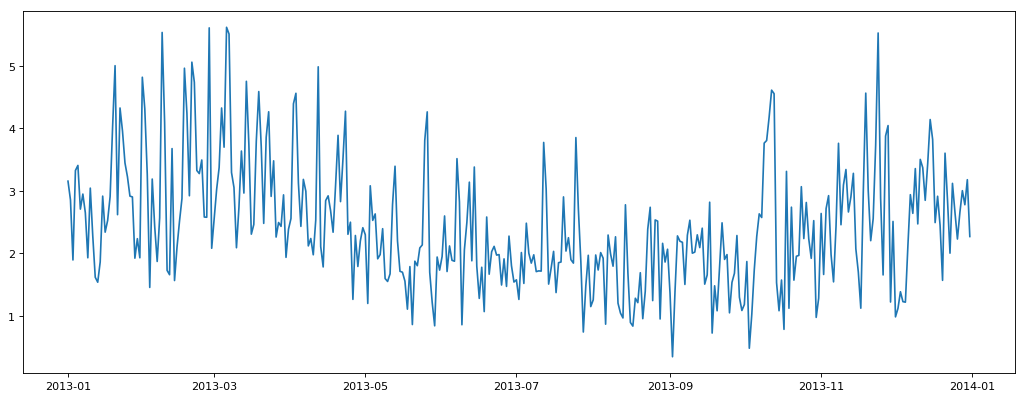

In [20]:
# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["date"],pdf["wind_speed"])

### Air Temperature

The next picture contains the average air temperature for every day in 2013.

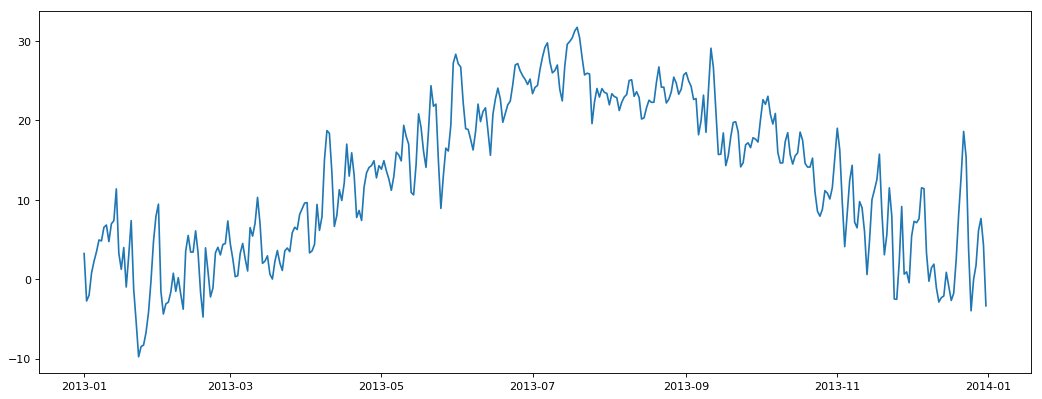

In [21]:
# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["date"],pdf["temperature"])

### Precipitation

The last picture contains the precipitation for every day in 2013.

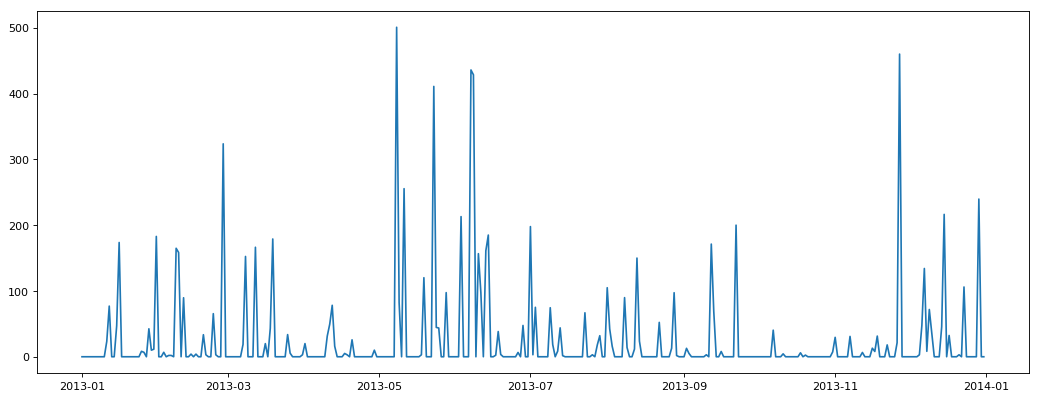

In [22]:
# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["date"],pdf["precipitation"])